# Coffee Prices Revisit

In [1]:
#libraries
import os #lets us interact with underlying operating system
import numpy as np #
from sklearn.linear_model import LinearRegression #if we want to use sklearn linear regression
import sklearn.preprocessing
from scipy.stats import boxcox
import statsmodels.api as sm
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#---Create 70/30 split for training and testing
#full_data_set = pd.read_csv('./Dataset/full_coffee_prices.csv')
#full_data_set['week_days'] = full_data_set['week_days'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
#training = full_data_set[0:4100]
#test = full_data_set[4100:]
#training.to_csv('./Dataset/full_coffee_prices_training.csv')
#test.to_csv('./Dataset/full_coffee_prices_test.csv')

In [3]:
#Read training data
training = pd.read_csv('./Dataset/full_coffee_prices_test.csv')

In [4]:
t = list(range(1, len(training) + 1))

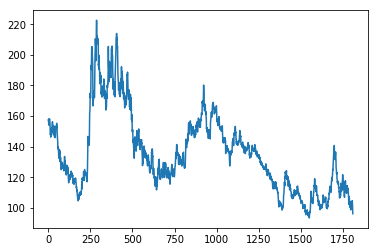

In [5]:
plt.plot(t,training['price'])
plt.show()

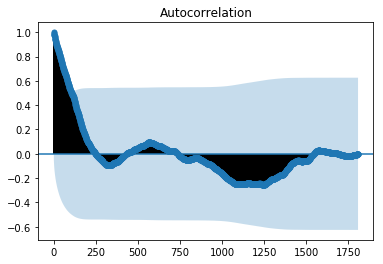

In [15]:
#First stage is exploratory work. Lets check how the data is looking.
#Time series we begin with checking ACF
full_series = sm.graphics.tsa.plot_acf(training['price'])

//anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


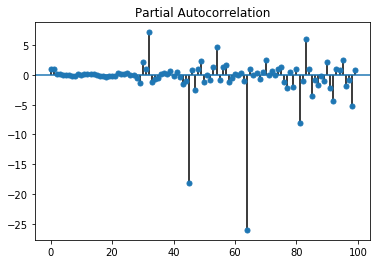

In [26]:
full_series = sm.graphics.tsa.plot_pacf(training['price'].head(100))

## We begin with transformations:
It's often difficult to just start on a time-series without prepping the data first. We usually perform
3 classes of transformation:
1. Distributional
2. Stationarity Inducing
3. Decompositional

**Distributional:** Many statistical procedures perform more effectively on data that are normally distributed
(or at least symmetric and not excessively kurtotic/fat-tailed). A common example is x >= 0, which is 
skewed right. We will need to make adjustments like natural log. The most popular way is a box-cox transform
using maximum likelihood to estimate lambda

Text(0.5, 0, 'Coffee Prices')

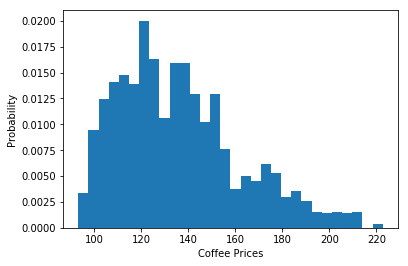

In [6]:
#We see a long-tail skewed right, which implies some log transformation may be appropriate here.
plt.hist(training['price'], density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Coffee Prices')

In [8]:
#Maximum likelihood estimation of lambda to a mu + at series
y,fitted_lambda= boxcox(training['price'],lmbda = None)
fitted_lambda

-0.937329079728135

Text(0.5, 0, 'Box-Cox Coffee Prices')

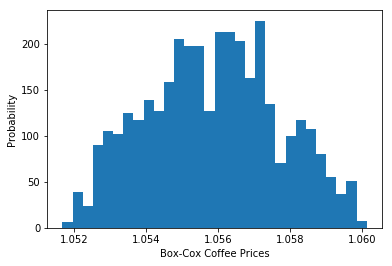

In [8]:
plt.hist(y, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Probability')
plt.xlabel('Box-Cox Coffee Prices')

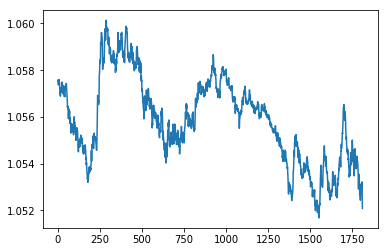

In [9]:
plt.plot(t,y)
plt.show()

**Stationary Inducing:** The second transformation is basic differencing to try and induce stationarity. Usually we would start with the first-difference and go from there. For some series like financial series, its common to take the percentage change rather than pure differencing. This can be shown to be the same as log difference. Since we already did Box-Cox, lets take first difference:

In [10]:
training['box_cox'] = y
training['box_cox_diff'] = training['box_cox'] - training['box_cox'].shift(1)

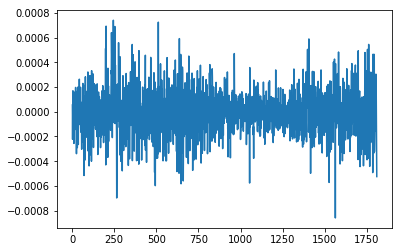

In [11]:
#This is looking great! Some periodicity with the spikes, but otherwise everything looks like white noise
plt.plot(t,training['box_cox_diff'])
plt.show()

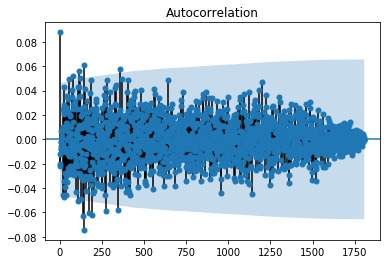

In [44]:
#Looking cleaner here, the band is smaller as well
full_series = sm.graphics.tsa.plot_acf(training['box_cox_diff'][1:], zero = False)

In [45]:
max(training['week_days'])

'2020-05-29'

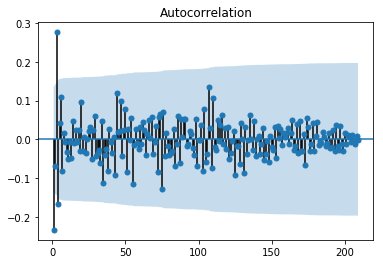

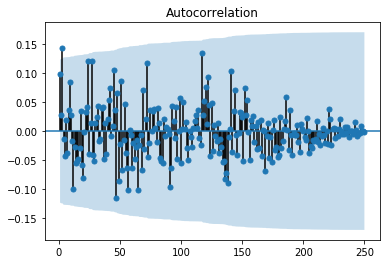

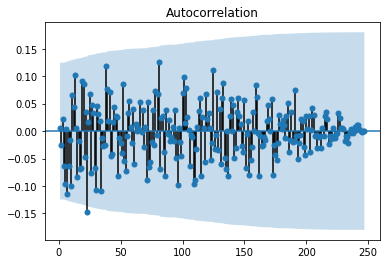

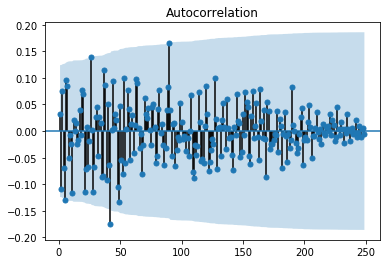

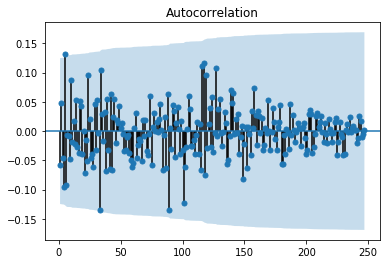

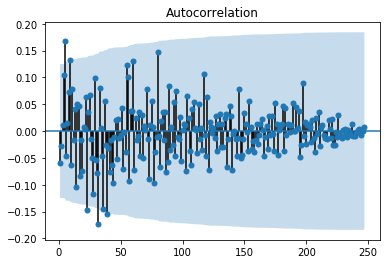

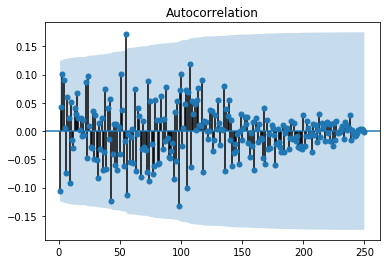

In [53]:
dates = ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', 
         '2019-01-01', '2020-01-01']

for i in range(len(dates)-1):
    year = training[(training['week_days'] >= dates[i]) & (training['week_days'] < dates[i+1])].dropna()
    full_series = sm.graphics.tsa.plot_acf(year['box_cox_diff'], zero = False)

Hard to see any clear patterns. 2019-2020 displays a bit of seasonality that might be interesting. Also our data after Box-Cox appears to be pretty normally distributed, so the 95% empirical rule could hold. For these annual ACF plots, most of the points lie within the +/- 2 sigma bands, suggesting autocorrelation levels that are consistent with white noise

//anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


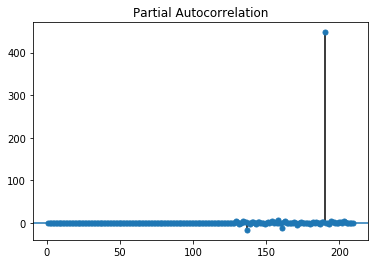

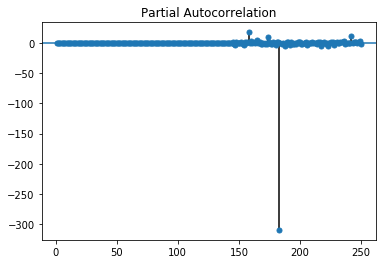

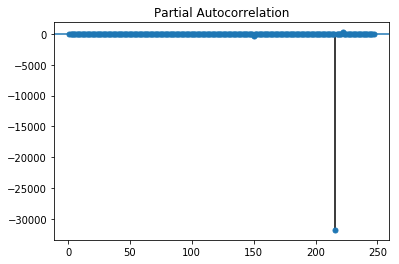

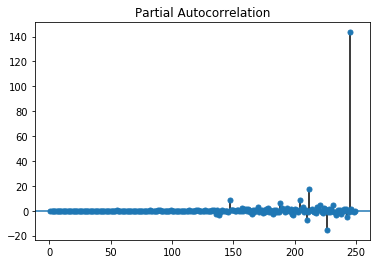

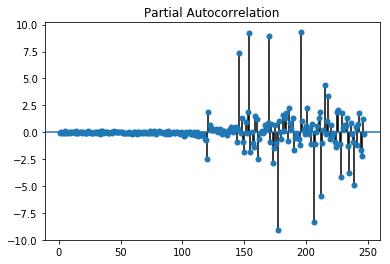

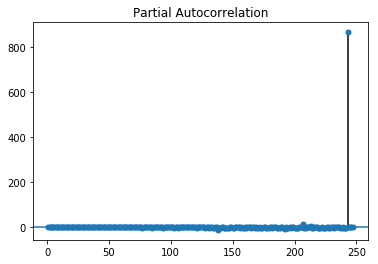

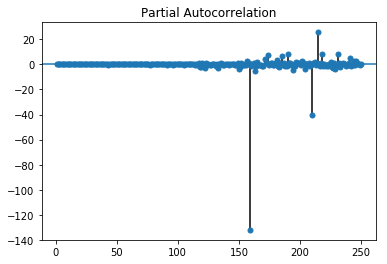

In [54]:
dates = ['2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', 
         '2019-01-01', '2020-01-01']

for i in range(len(dates)-1):
    year = training[(training['week_days'] >= dates[i]) & (training['week_days'] < dates[i+1])].dropna()
    full_series = sm.graphics.tsa.plot_pacf(year['box_cox_diff'], zero = False)

PACF measures the additional correlation between xt and xt-k. This is achieved by fitting a linear model (with regular betas) of xt = B1*xt-1 + B2 *xt-2 +..... and the same for xt-k. Then subtract both actual values with their fitted value to essentially "explain away" the correlation coming from previous points. Now calculate the correlation between the Cov(xt - xt-hat, xt-k - xt-k - hat) as the PACF. We're seeing statistically significant spikes in PACF for multiple years which may suggest a yearly effect.

//anaconda/lib/python3.5/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


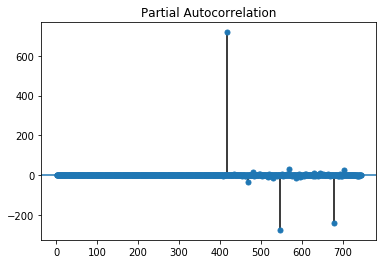

In [57]:
two_year = training[(training['week_days'] >= '2016-01-01') & (training['week_days'] < '2019-01-01')].dropna()
full_series = sm.graphics.tsa.plot_pacf(two_year['box_cox_diff'], zero = False)